In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 



In [2]:
df = pd.read_csv(r"E:\gnn project\ForEx\GBPINR\gbp_inr.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair,Deseasonalized_Day_high,Deseasonalized_Day_low,...,EMA_100,EMA_200,EMA_50,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0,7851,2014-11-07,97.6145,97.7156,97.1888,97.4138,GBP/INR,97.756749,97.234088,...,97.413800,97.413800,97.413800,0.0,0.000000,0.000000,0.000000,97.032375,97.875611,96.189139
1,1,7852,2014-11-10,97.4982,97.9802,97.3621,97.5163,GBP/INR,97.978845,97.374370,...,97.415830,97.414820,97.417820,0.0,0.008177,0.001635,0.006541,97.032375,97.875611,96.189139
2,2,7853,2014-11-11,97.6663,98.0336,97.5695,97.9538,GBP/INR,97.994560,97.511927,...,97.426483,97.420183,97.438838,0.0,0.049390,0.011186,0.038204,97.032375,97.875611,96.189139
3,3,7854,2014-11-12,97.8621,98.0328,96.6934,96.7051,GBP/INR,97.946457,96.626502,...,97.412198,97.413068,97.410064,0.0,-0.018495,0.005250,-0.023745,97.032375,97.875611,96.189139
4,4,7855,2014-11-13,96.7591,97.1627,96.5200,96.6187,GBP/INR,97.063731,96.445151,...,97.396485,97.405163,97.379030,0.0,-0.078362,-0.011472,-0.066890,97.032375,97.875611,96.189139


In [3]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'Open_price', 'Day_high',
       'Day_low', 'Closing_price', 'Currency Pair', 'Deseasonalized_Day_high',
       'Deseasonalized_Day_low', 'Deseasonalized_Open_price', 'EMA_100',
       'EMA_200', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
       'SMA', 'Upper Band', 'Lower Band'],
      dtype='object')

## Linear regression

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# === Load and prepare ===
# Assume df is already a pandas DataFrame with the columns you mentioned
df = df.copy()
df = df.dropna().reset_index(drop=True)

# --- Features and Target ---
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'   # or 'Deseasonalized_Day_high' etc.

X = df[features]
y = df[target]

# === Walk-forward validation ===
tscv = TimeSeriesSplit(n_splits=5)
lr = LinearRegression()

all_metrics = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    # --- Regression metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # --- Trading metrics ---
    pred_returns = pd.Series(y_pred, index=y_test.index).pct_change().fillna(0)
    actual_returns = df.loc[y_test.index, 'Closing_price'].pct_change().fillna(0)

    # Simple strategy: go long if predicted return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=y_test.index)

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    # Directional Accuracy
    def directional_accuracy(actual, predicted):
        actual_diff = np.diff(actual)
        pred_diff = np.diff(predicted)
        return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

    da = directional_accuracy(y_test.values, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect Results ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)

# === Average performance ===
print("\nAverage performance across folds:")
print(metrics_df.mean())


   Fold       MAE      RMSE        R2     ROI(%)    Sharpe  MaxDrawdown  \
0     1  0.591863  0.660780  0.937909  77.196324  0.445879    -0.010145   
1     2  0.235355  0.306608  0.986278  78.809688  0.439158    -0.011608   
2     3  0.291528  0.412600  0.989240  83.097512  0.506913    -0.007030   
3     4  0.265120  0.359346  0.988363  78.360634  0.469030    -0.010583   
4     5  0.189008  0.240363  0.991193  56.962405  0.515879    -0.005112   

   DirAcc(%)  
0  78.899083  
1  79.128440  
2  78.440367  
3  79.357798  
4  79.816514  

Average performance across folds:
Fold            3.000000
MAE             0.314575
RMSE            0.395939
R2              0.978596
ROI(%)         74.885313
Sharpe          0.475372
MaxDrawdown    -0.008896
DirAcc(%)      79.128440
dtype: float64


Rolling Walk-Forward MAE: 0.2507, RMSE: 0.3385, R2: 0.9980
Directional Accuracy: 78.89%


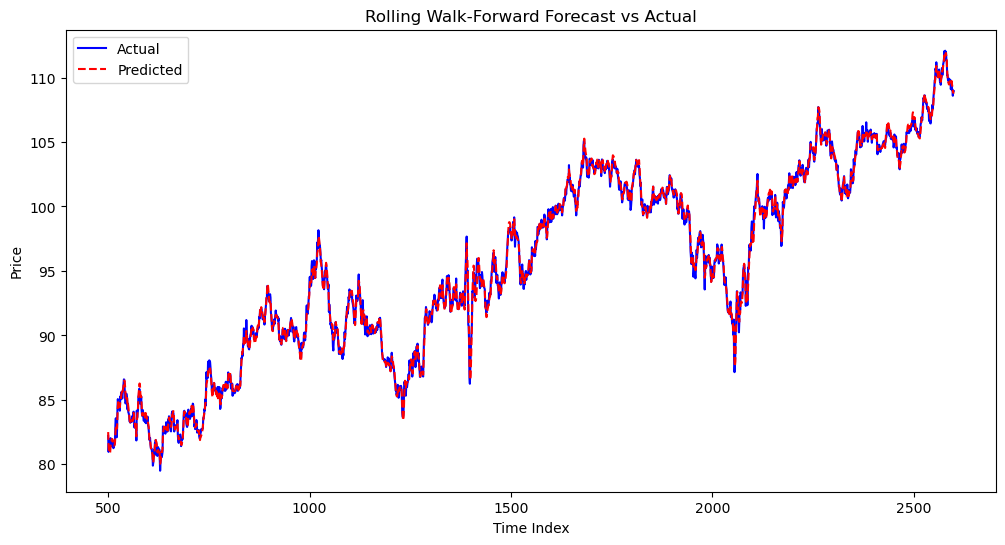

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
df = df.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'  # or try 'Deseasonalized_Day_high', etc.

X = df[features].values
y = df[target].values

# === Walk-forward params ===
train_window = 500   # how many samples in each rolling train set
test_window = 30     # how many samples to predict forward each step

lr = LinearRegression()

# Store results
all_preds, all_actuals, all_idx = [], [], []

for start in range(0, len(X) - train_window - test_window, test_window):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

# Convert to Series
y_actual_series = pd.Series(all_actuals, index=all_idx)
y_pred_series = pd.Series(all_preds, index=all_idx)

# === Metrics ===
mae = mean_absolute_error(y_actual_series, y_pred_series)
rmse = np.sqrt(mean_squared_error(y_actual_series, y_pred_series))
r2 = r2_score(y_actual_series, y_pred_series)

print(f"Rolling Walk-Forward MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Directional Accuracy
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

da = directional_accuracy(y_actual_series.values, y_pred_series.values)
print(f"Directional Accuracy: {da:.2f}%")

# === Plot results ===
plt.figure(figsize=(12,6))
plt.plot(y_actual_series.index, y_actual_series, label="Actual", color="blue")
plt.plot(y_pred_series.index, y_pred_series, label="Predicted", color="red", linestyle="dashed")
plt.title("Rolling Walk-Forward Forecast vs Actual")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.show()


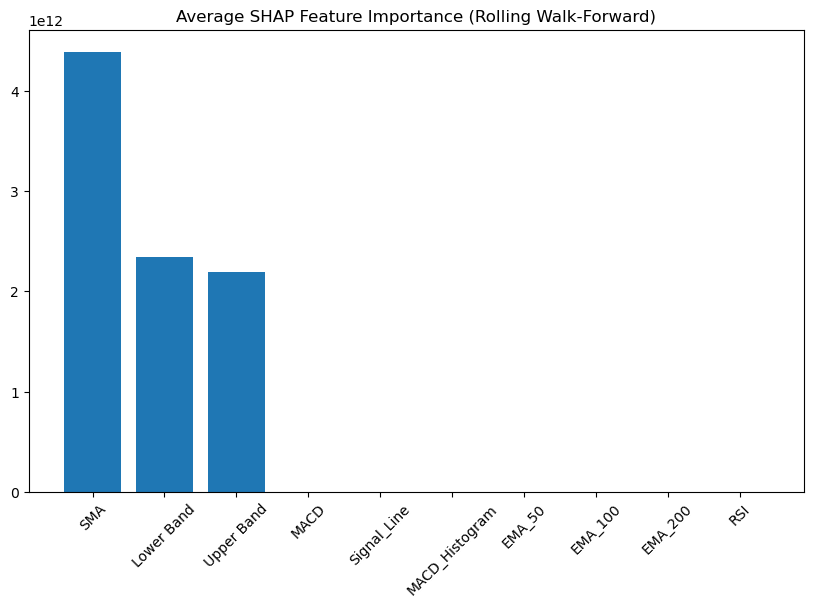

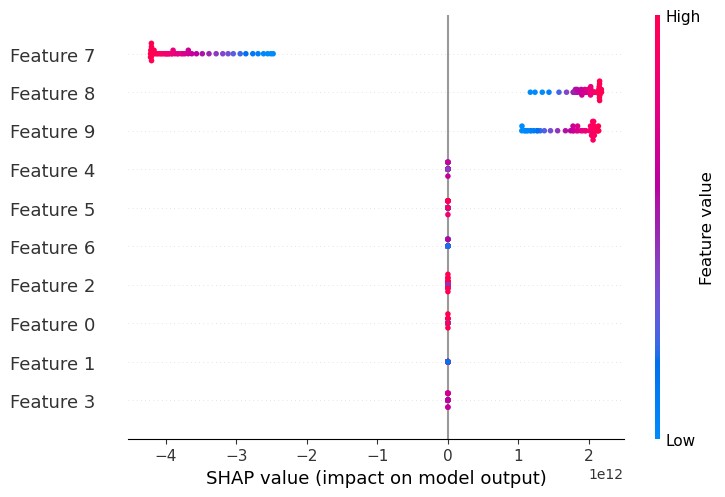

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === SHAP on Rolling Walk-Forward ===
train_window = 500
test_window = 30
features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]

X = df[features].values
y = df['Closing_price'].values

lr = LinearRegression()

all_shap_values = []
all_feature_importance = []

for start in range(0, len(X) - train_window - test_window, test_window):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test = X[end:end+test_window]
    
    # Fit
    lr.fit(X_train, y_train)
    
    # SHAP Explainer
    explainer = shap.Explainer(lr, X_train)
    shap_values = explainer(X_test)
    
    # Aggregate mean absolute shap values (feature importance for this window)
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    all_feature_importance.append(mean_abs_shap)

# Convert to array
all_feature_importance = np.array(all_feature_importance)

# === Plot Average Feature Importance Across Walk-Forward ===
mean_importance = all_feature_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()

# === Optional: Waterfall/Beeswarm for last window ===
shap.plots.beeswarm(shap_values, show=True)


## KNN

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  3.595803  3.743200 -8.138286  1.804730  0.118903    -0.015075   
1      2  1.092367  1.221072 -0.452257 -0.411999 -0.041715    -0.012352   
2      3  0.678227  0.808141  0.255584  3.430450  0.183989    -0.022273   
3      4  1.252023  1.474434 -0.685046  0.871281  0.081473    -0.016745   
4      5  2.148042  2.254892 -3.385017  7.848365  0.529910    -0.002124   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.434450  0.509334  0.344844  2.825929  0.455281    -0.002325   
66    67  0.383328  0.457270 -0.071473  0.545166  0.096643    -0.008964   
67    68  1.305765  1.468418 -1.051098  1.381993  0.178923    -0.008549   
68    69  2.129300  2.234427 -1.481642  4.371227  0.550077    -0.002194   
69    70  2.686331  2.870701 -6.735929  2.194599  0.424142    -0.000428   

    DirAcc(%)  
0   31.034483  
1   48.275862  
2   62.068966  
3   55.172414  
4   75.862069  
.. 

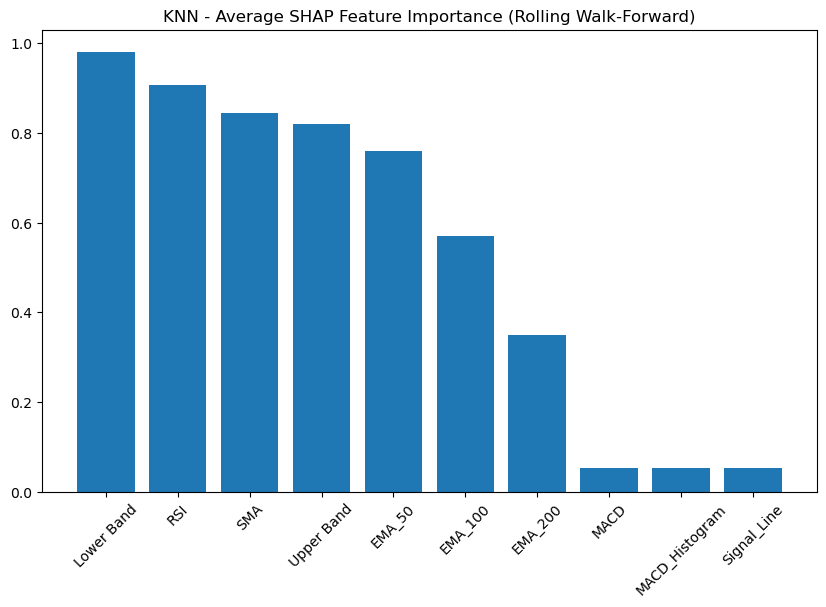

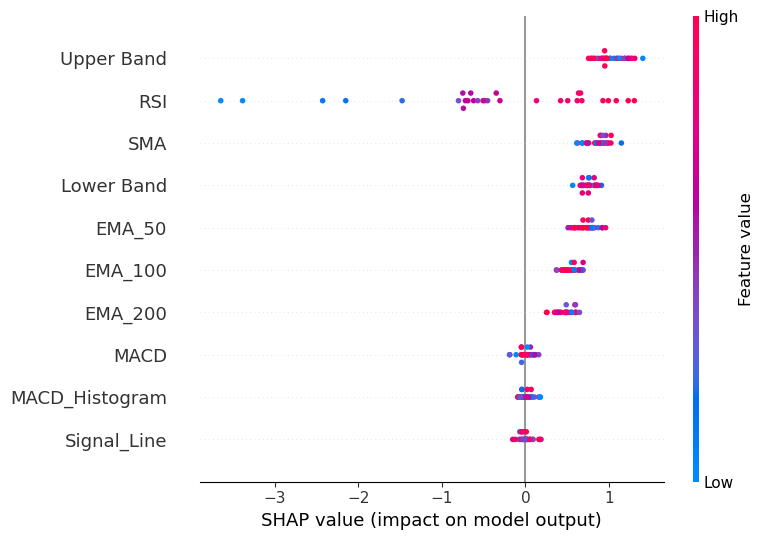

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

knn = KNeighborsRegressor(n_neighbors=5)

all_preds, all_actuals, all_idx = [], [], []
all_feature_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Fit model
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP (KernelExplainer) ---
    background = shap.sample(X_train, 100)  # subset for speed
    explainer = shap.KernelExplainer(knn.predict, background)
    shap_values = explainer.shap_values(X_test, nsamples=100)

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    all_feature_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Predicted vs actual returns
    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    # Strategy: long if pred_return > 0
    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics into DataFrame ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === Average SHAP importance ===
all_feature_importance = np.array(all_feature_importance)
mean_importance = all_feature_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("KNN - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()

# === SHAP Beeswarm for last window ===
shap.summary_plot(shap_values, X_test, feature_names=features)


## Catboost

    Fold       MAE      RMSE        R2    ROI(%)    Sharpe  MaxDrawdown  \
0      1  3.905446  4.067441 -9.789997  3.959344  0.205416    -0.015509   
1      2  1.160702  1.405860 -0.925064  0.525796  0.051414    -0.016972   
2      3  0.454647  0.559464  0.643232  5.784286  0.305081    -0.009288   
3      4  0.805191  0.936821  0.319740  0.429636  0.037686    -0.015307   
4      5  1.656762  1.728223 -1.575841  7.044947  0.461696    -0.004980   
..   ...       ...       ...       ...       ...       ...          ...   
65    66  0.242893  0.283186  0.797473  2.692290  0.339425    -0.005112   
66    67  0.413032  0.491665 -0.238724  2.181531  0.472771    -0.000537   
67    68  1.049651  1.168108 -0.297936  3.313217  0.459013    -0.004089   
68    69  1.690561  1.832426 -0.669014  5.032657  0.611295    -0.002575   
69    70  1.876363  1.935491 -2.516568  2.570202  0.439410    -0.001948   

    DirAcc(%)  
0   58.620690  
1   68.965517  
2   82.758621  
3   65.517241  
4   82.758621  
.. 

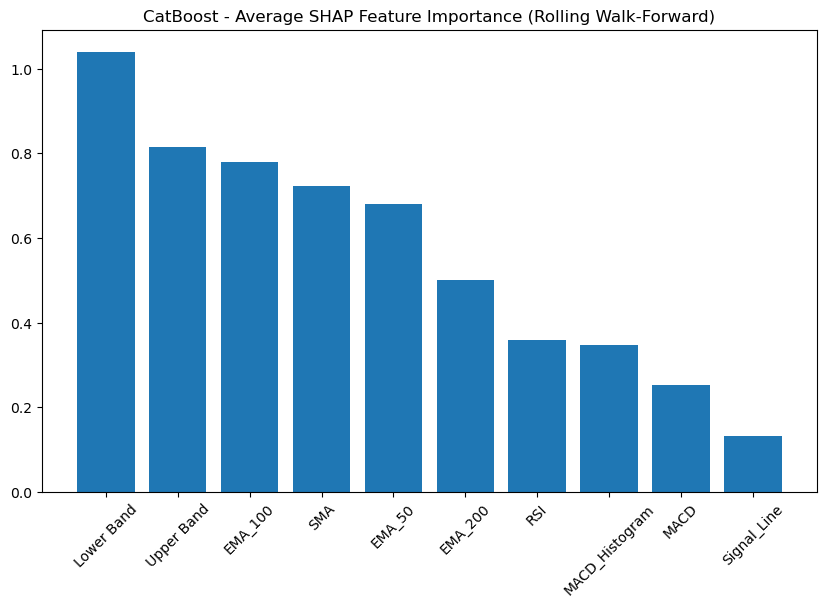

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Prepare Data ===
# df = jpy_inr.copy().dropna().reset_index(drop=True)

features = [
    'EMA_100', 'EMA_200', 'EMA_50',
    'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
    'SMA', 'Upper Band', 'Lower Band'
]
target = 'Closing_price'

X = df[features].values
y = df[target].values

# === Walk-forward parameters ===
train_window = 500
test_window = 30

cat = CatBoostRegressor(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=0,
    random_seed=42
)

all_preds, all_actuals, all_idx = [], [], []
all_shap_importance, all_metrics = [], []

def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100

for fold, start in enumerate(range(0, len(X) - train_window - test_window, test_window), 1):
    end = start + train_window
    X_train, y_train = X[start:end], y[start:end]
    X_test, y_test = X[end:end+test_window], y[end:end+test_window]

    # Wrap into CatBoost Pool
    train_pool = Pool(X_train, y_train, feature_names=features)
    test_pool = Pool(X_test, y_test, feature_names=features)

    # Fit model
    cat.fit(train_pool)
    y_pred = cat.predict(test_pool)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)
    all_idx.extend(range(end, end+test_window))

    # --- SHAP values from CatBoost ---
    shap_values = cat.get_feature_importance(type="ShapValues", data=test_pool)
    # Last column of shap_values is expected_value, drop it
    shap_contribs = shap_values[:, :-1]
    mean_abs_shap = np.abs(shap_contribs).mean(axis=0)
    all_shap_importance.append(mean_abs_shap)

    # --- Metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    pred_returns = pd.Series(y_pred, index=range(end, end+test_window)).pct_change().fillna(0)
    actual_returns = pd.Series(y_test, index=range(end, end+test_window)).pct_change().fillna(0)

    strategy_returns = np.where(pred_returns > 0, actual_returns, 0)
    strategy_returns = pd.Series(strategy_returns, index=range(end, end+test_window))

    roi = strategy_returns.sum() * 100
    sharpe = (strategy_returns.mean() / strategy_returns.std()) if strategy_returns.std() != 0 else 0
    cumulative = (1 + strategy_returns).cumprod()
    drawdown = (cumulative - cumulative.cummax()) / cumulative.cummax()
    max_dd = drawdown.min()

    da = directional_accuracy(y_test, y_pred)

    all_metrics.append([fold, mae, rmse, r2, roi, sharpe, max_dd, da])

# === Collect metrics ===
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Fold', 'MAE', 'RMSE', 'R2', 'ROI(%)', 'Sharpe', 'MaxDrawdown', 'DirAcc(%)'
])
print(metrics_df)
print("\nAverage performance across folds:")
print(metrics_df.mean())

# === SHAP importance (average) ===
all_shap_importance = np.array(all_shap_importance)
mean_importance = all_shap_importance.mean(axis=0)
sorted_idx = np.argsort(mean_importance)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), mean_importance[sorted_idx])
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.title("CatBoost - Average SHAP Feature Importance (Rolling Walk-Forward)")
plt.show()
